# Setup

In [ ]:
# Package Installs

!pip install dicom2nifti
!pip install torchio
!pip install pytorch-lightning
!pip install wandb

In [37]:
#Imports
from google.colab import drive
import dicom2nifti

In [ ]:
drive.mount('/content/drive')  # Allowing colab to read your drive files

In [ ]:
# Unzipping the file with imaging data
# Top level is patients
# Seconds level is examinations, should be two per patient
# Third level is imaging series
# Fourth level is the dicom images making up the series
!unzip drive/MyDrive/archive.zip 

In [15]:
#Converting each series to a nifti file, the below converts every sequence for one examination of patient 1
dicom2nifti.convert_directory("Brain-Tumor-Progression/PGBM-001/04-02-1992-FH-HEADBrain Protocols-79896", ".", compression=True, reorient=True)

In [ ]:
# TO DO:
# Convert Every series for each patient from DICOM to Nifti

In [33]:
!ls

11_t1post.nii.gz	35628_srcbv_reg.nii.gz	Brain-Tumor-Progression
29904_dt1.nii.gz	35629_nrcbv_reg.nii.gz	drive
34907_t1pre_reg.nii.gz	35630_ncbf_reg.nii.gz	sample_data
35623_flair_reg.nii.gz	37908_t2_reg.nii.gz
35624_adc_reg.nii.gz	5388_mask_tumor.nii.gz


# Data Exploration

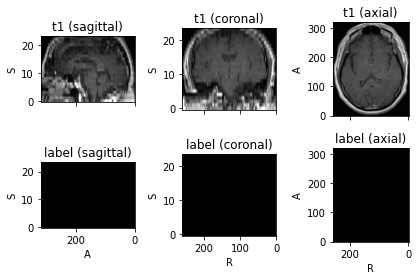

In [32]:
#Imports
import torchio as tio #TorchIO has a lot of tools for working with Neuroimaging data

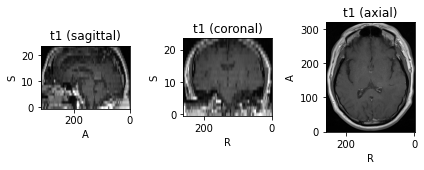

In [44]:
subject_a = tio.Subject(
    t1=tio.ScalarImage('11_t1post.nii.gz'),
    progression = False,
)
subject_a.plot()

# Creating Dataset


In [45]:
#Imports
import tqdm
import torchio as tio
import os
import torch

In [ ]:
# Create a TorchIO dataset by modifying the below code to read your data, in your case you will need to determine how to combine the first and second examination data
subjects = []
base_dir = ""
for file in tqdm.tqdm([file for file in os.listdir(base_dir) if os.path.isdir(base_dir + '/'+file) == True]):
    paths = [os.path.join(base_dir,file,file+f'_{chan}.nii.gz') for chan in input_channels_list]        
    subject = tio.Subject(            
        data = tio.ScalarImage(path = paths),
        progression = False,
        name = file
    )
    subjects.append(subject)  
    
dataset = tio.SubjectsDataset(subjects)

In [56]:
# Example Transforms to apply to data, these may not work for your problem
training_transform = tio.Compose([
    tio.ZNormalization(masking_method=tio.ZNormalization.mean), 
    tio.RandomNoise(p=0.5),
    tio.RandomGamma(log_gamma=(-0.3, 0.3)),
    tio.RandomElasticDeformation(),
    tio.CropOrPad((240, 240, 160)),
])

validation_transform = tio.Compose([
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.CropOrPad((240, 240, 160)),          
])

In [ ]:
#Splitting datasets into training and validation
training_split_ratio = 0.8


num_subjects = len(dataset)
print('Num Subjects: ',num_subjects)
num_training_subjects = int(training_split_ratio * num_subjects)
num_validation_subjects = num_subjects - num_training_subjects
num_split_subjects = num_training_subjects, num_validation_subjects
generator=torch.Generator().manual_seed(seed)
training_subjects, validation_subjects = torch.utils.data.random_split(subjects, num_split_subjects,generator)
training_set = tio.SubjectsDataset(training_subjects, training_transform)
validation_set = tio.SubjectsDataset(validation_subjects, validation_transform)

# PyTorch Lightning Model

In [50]:
#Imports
import torch
import pytorch_lightning as pl

In [ ]:
class TumourProgression(pl.LightningModule):
    def __init__(self, train_dataset, val_dataset, col_fn, learning_rate, num_loading_cpus=1, batch_size=1, ...):
        super().__init__()  
        self.model = ...
        self.learning_rate = learning_rate
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.col_fn = col_fn
        self.batch_size = batch_size 
        self.num_loading_cpus=num_loading_cpus
        ...

    def forward(self,x):
        f = self.model.forward(x)
        return f

    def training_step(self, batcb):
        ...
        y = ...
        y_hat = self.forward(x)
        loss = your_loss_func(y_hat,y)
        ...
        return loss

    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dataset,batch_size=self.batch_size,num_workers=self.num_loading_cpus,collate_fn=self.col_fn)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dataset,batch_size=self.batch_size,num_workers=self.num_loading_cpus,collate_fn=self.col_fn)     

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.learning_rate)

In [ ]:
# Build your model

model = TumourProgression(
        train_dataset=training_set,
        val_dataset=validation_set,
        col_fn=col_fn, #TO DO: Write collation function
        batch_size=batch_size,
        num_loading_cpus=num_loading_cpus,
        learning_rate=learning_rate,
        ... ## ADD REST OF MODEL INIT ARGS
    )

# Training

In [59]:
#Imports
import pytorch_lightning as pl

In [60]:
# Logger
wandb_logger = pl.loggers.WandbLogger(project=wandb_project_name,name=wandb_run_name, offline = False)

NameError: ignored

In [ ]:
# Trainer
trainer = pl.Trainer(
    default_root_dir=default_root_dir,
    accumulate_grad_batches=accumulate_grad_batches,
    gpus=gpus,
    max_epochs=max_epochs,
    precision=precision,
    check_val_every_n_epoch=check_val_every_n_epoch,        
    log_every_n_steps=log_every_n_steps,      
    val_check_interval=val_check_interval,
    progress_bar_refresh_rate=progress_bar_refresh_rate,
    logger = wandb_logger
    ...
)
trainer.fit(model)

#OUTPUT
torch.save(model.model.state_dict(), output_model_path)

# Evaluation